# 3D example:

The operator here is $$\Phi \mu = \int \phi(x,y,t) \mathrm{d}\mu(x,y,t)$$ where
$$
\phi(x,y,t) =\left(\exp(-(x_i - x)^2/(2\sigma^2)) \exp(-(y_j-y)^2/(2\sigma)) \exp(-s_k t) \right)_{i,j,k}
$$

In [69]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import time

import mmd as mmd
import operators as myops
import lasso as ls
import continuous_BP as cbp
from helper import prune, generate_plots
from importlib import reload  # Python 3.4+
from numpy import linspace

reload(ls)
reload(myops)
reload(cbp)

<module 'continuous_BP' from '/Users/u2272691/Documents/GitHub/continuous-BP/Python/cBP_paper/continuous_BP.py'>

In [70]:
#define Lasso solver

def Grid_Lasso(X,Y,B,y_obs,la,tol=1e-8):   
    #forward and adjoint operations
    def FWD_lasso(x):
        x0 = x[:,:,0]
        return dot(dot(X,dot(Y,x0)),B.T)

    def ADJ_lasso(x):
        z = dot(dot(X.T,dot(Y.T,x)),B)
        return z[:,:,None]  
    #run lasso solver
    a = ls.Lasso_Tensor(FWD_lasso,ADJ_lasso, y_obs,la)
    return a


def generate_random_signal(s,xgrids,shift,minsep,pos=True):
    
    T = []
    for i in range(len(xgrids)):
        xgrid = xgrids[i]
        P = np.random.permutation(len(xgrid)//minsep[i])
        idx = P[:s]*minsep[i]
        t0 = xgrid[idx]  + shift[i]
        T.append(t0)
    if pos:
        a = np.random.rand(s,)+2
    else:
        a = (np.random.rand(s,)+2)*np.sign(np.random.randn(s,))+1j* (np.random.rand(s,)+2)*np.sign(np.random.randn(s,))
    return a, np.stack(T,axis=1) #np.stack((t0, np.random.permutation(t1)),axis=1)


In [90]:
np.random.seed(1)

from  numpy import dot as dot
N = 50
nx= [N,N,10]
xgrid0 = linspace(0,1,nx[0])
xgrid1 = linspace(0,1,nx[1])
xgrid2 = linspace(0,1,nx[2])
grid_arr = [xgrid0,xgrid1,xgrid2]
points = np.array([np.array([x,y,z]) for x in xgrid1 for y in xgrid1 for z in xgrid2])

#define the operator matrices
tvec = np.linspace(0,1,10)
sigma=0.1
Xop, X, dX = myops.getGaussianMatrices(tvec,sigma,xgrid1)
Yop, Y, dY = myops.getGaussianMatrices(tvec,sigma,xgrid1)

T = 2
tvec2 = np.linspace(0,1,T)
Psi,  B, dB = myops.getLaplaceMatrices(tvec2,xgrid2)


#define ground truth
h0 = xgrid0[1]-xgrid0[0]
h1 = xgrid1[1]-xgrid1[0]
h2 = xgrid2[1]-xgrid2[0]

spacing = np.array([0.1,0.1,.1])
shift = np.array([h0,h1,-h2])*spacing


Runs = 10
L=10
la_vals = np.linspace(1e-5,0.2,L)
#la_vals = np.logspace(-5,np.log10(0.005),L)

err_lasso =  np.zeros((L,Runs))
err_srlasso = np.zeros((L,Runs))

supp_lasso = np.zeros((L,Runs))
supp_srlasso = np.zeros((L,Runs))

for i in range(L):
    la = la_vals[i]

    for r in range(Runs):
        
        s=3
        minsep = np.array(nx)//5
        a_true,x_true = generate_random_signal(s,grid_arr,shift,minsep,pos=True)
        y_true = np.einsum('nj,kj,lj->nkl', Xop(x_true[:,0]),Yop(x_true[:,1]), Psi(x_true[:,2])*a_true[None,:]) 
        noise_lev = 0.00001
        y_obs = y_true + noise_lev*np.random.randn( *y_true.shape)



        #rerun both with same noise instance
        #Call SR Lasso
        tol=1e-2
        tau1,tau2= 1,1
        a,b1,b2,b3 = cbp.SRLasso_3DTensor(X,Y,B,dX,dY,dB, y_obs,la,[tau1,tau1,tau2])
        a,grid = prune( a, points + np.stack((b1,b2,b3),axis=1),tol)

        a_lasso = Grid_Lasso(X,Y,B,y_obs,la,1e-2)
        a_lasso, grid_lasso = prune(a_lasso.reshape(-1),points,tol)


        err_srlasso[i,r] = mmd.mmd_laplace(x_true, a_true,grid,a)
        err_lasso[i,r] = mmd.mmd_laplace(x_true, a_true,grid_lasso,a_lasso)
        
        supp_srlasso[i,r] = len(a)
        supp_lasso[i,r] = len(a_lasso)


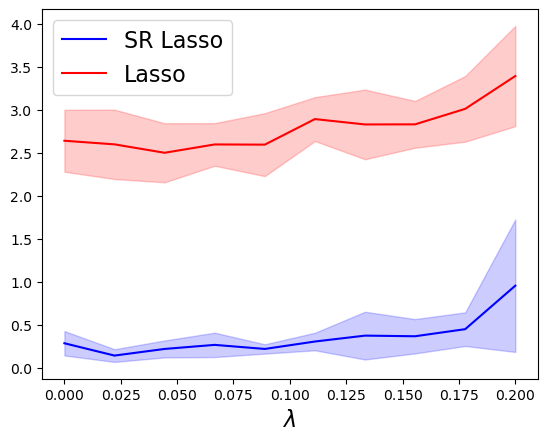

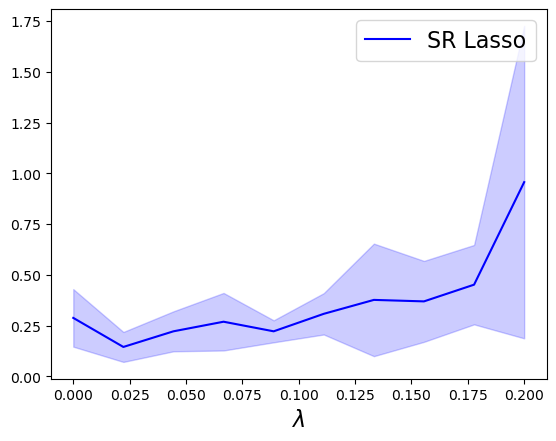

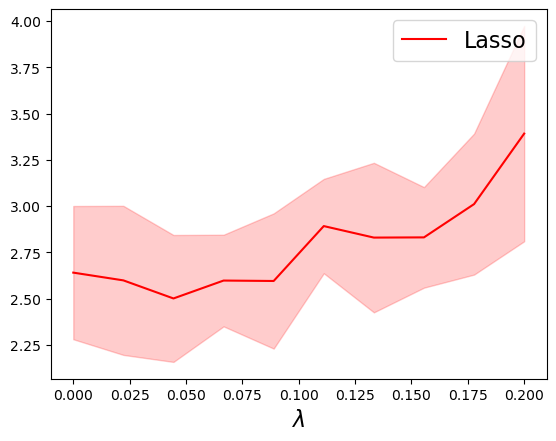

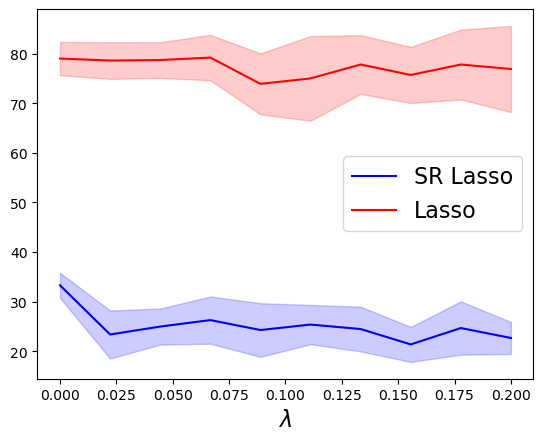

In [91]:
import helper
reload(helper)
Plots = [err_srlasso,err_lasso]
labels = ['SR Lasso','Lasso']
filename = '3DFourier_'+'N'+str(nx[0])+'s'+str(s)+'Err'+'.png'
helper.generate_plots(Plots, labels,filename,xlabel='$\lambda$', xaxis = la_vals)


Plots = [err_srlasso]
labels = ['SR Lasso']
filename = '3DFourier_'+'N'+str(nx[0])+'s'+str(s)+'SRLErr'+'.png'
helper.generate_plots(Plots, labels,filename,xlabel='$\lambda$', xaxis = la_vals,color =  (0,0,1))



Plots = [err_lasso]
labels = ['Lasso']
filename = '3DFourier_'+'N'+str(nx[0])+'s'+str(s)+'LassoErr'+'.png'
helper.generate_plots(Plots, labels,filename,xlabel='$\lambda$', xaxis = la_vals,color =  (1,0,0))



Plots = [supp_srlasso,supp_lasso]
labels = ['SR Lasso','Lasso']
filename = '3DFourier_'+'N'+str(nx[0])+'s'+str(s)+'Supp'+'.png'
helper.generate_plots(Plots, labels,filename,xlabel='$\lambda$', xaxis = la_vals)
